<a href="https://colab.research.google.com/github/openknowledge/mlops-data2day/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase I: Exploration


In [1]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
tf.random.set_seed(42)

In [3]:
import numpy as np
np.__version__

'1.21.6'

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [5]:
# https://github.com/AndreasMadsen/python-lrcurve
# !pip install -q lrcurve

     |████████████████████████████████| 71 kB 9.0 MB/s 
     |████████████████████████████████| 1.6 MB 54.8 MB/s 


In [6]:
from lrcurve import KerasLearningCurve

# Step 1: Loading and exploring our data set

In [7]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/openknowledge/mlops-data2day/main/data/reference.csv', delimiter=';')

In [8]:
df.head()

,training,age,emergency_breaking,braking_distance,power,miles,risk,group_name,group
0,0,41.951100,0,40.933328,122.238329,98.509765,3.715019,high,0
1,0,24.368286,1,44.797317,113.765298,46.324178,2.432928,medium,1
2,0,18.314649,1,41.587241,143.427269,76.862968,4.064888,high,0
3,0,51.265254,1,47.266716,111.578133,102.697069,5.102777,high,0
4,0,23.578861,0,42.835319,145.994235,63.690055,3.724353,high,0


In [9]:
df.describe()

,training,age,emergency_breaking,braking_distance,power,miles,risk,group
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.146663,0.394000,39.903294,134.888089,80.965668,2.181697,0.900000
std,0.407444,12.765348,0.488798,4.781834,35.048570,25.496752,2.482389,0.815543
min,0.000000,15.949545,0.000000,24.368993,38.246253,18.796953,-5.274407,0.000000
25%,0.000000,25.141921,0.000000,36.733165,110.008660,62.666195,0.708686,0.000000
50%,0.000000,32.714683,0.000000,39.867888,131.055019,77.094819,2.392071,1.000000
75%,0.000000,42.633629,1.000000,42.938777,157.319959,95.568682,3.867287,2.000000
max,1.000000,86.213394,1.000000,56.463472,285.750164,211.807417,10.358000,2.000000


In [10]:
import seaborn as sns

In [11]:
labels = ["High Risk", "Medium Risk", "Low Risk"]
markers = ['v', 'd', '^']
# colors = ['#FF8080', '#FFFF80', '#8080FF']
colors = ['#FF0000', '#FFFF00', '#0000FF']

In [12]:
features = ['training', 'age', 'emergency_breaking', 'braking_distance', 'power', 'miles', 'risk']

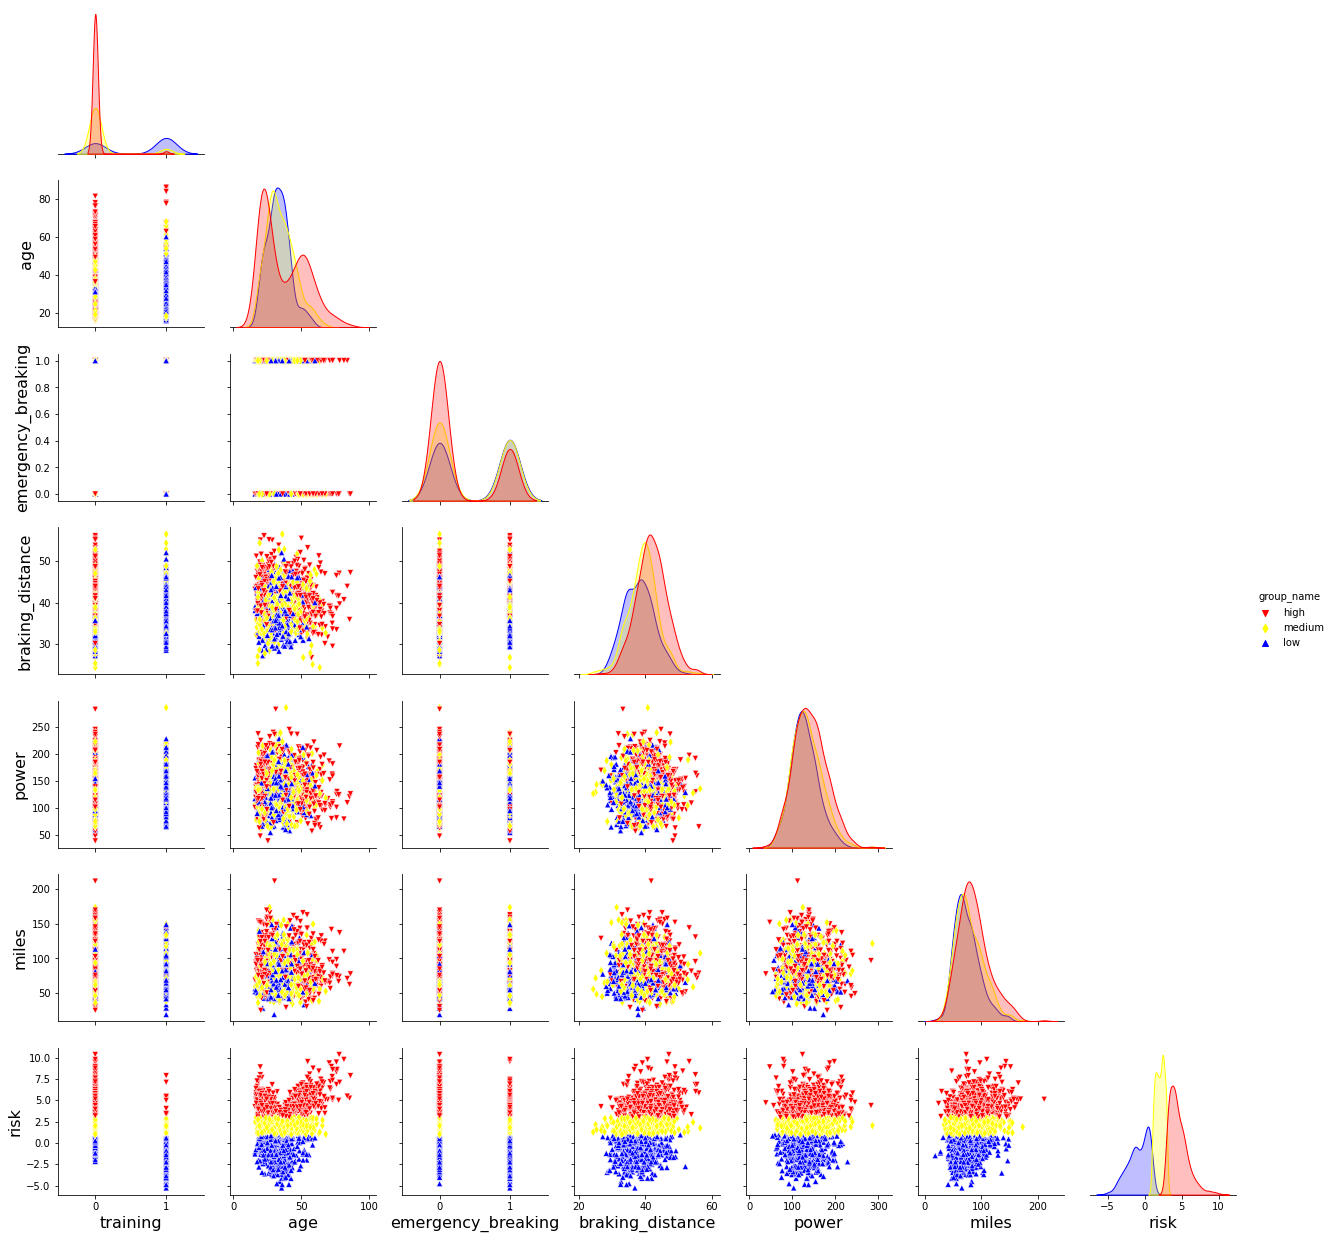

In [13]:
sns.pairplot(df, 
             kind="scatter", 
             diag_kind="kde",
             corner=True, 
             hue='group_name',
             hue_order = ['high', 'medium', 'low'],
             palette=colors, 
             markers=markers,
             vars=features);

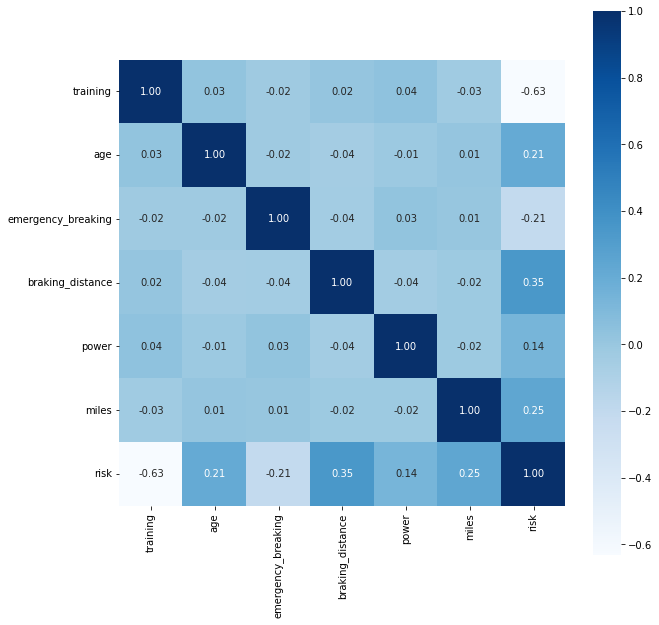

In [14]:
plt.figure(figsize=(10, 10))

cm = df.corr()
cm3 = cm.iloc[:len(features), :len(features)]

hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                cmap='Blues', 
                fmt='.2f',
                yticklabels=features,
                xticklabels=features)

# Step 2: Training a neural network

In [15]:
y = df['group'].values
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([581, 488, 431]))

In [16]:
# df.columns

In [17]:
X = df.drop(['risk', 'group', 'group_name'], axis='columns').values
# simplify to 2 dimensions to make this more interpretable
# X = df[['age', 'power']].values
X.shape, y.shape

((1500, 6), (1500,))

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 6), (300, 6), (1200,), (300,))

## Normalization

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization

In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [20]:
normalizer.adapt(X_train)

In [21]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([  0.21916667,  34.9826181 ,   0.38916667,  39.93096172,
        136.06711555,  81.1859176 ]),
 array([ 0.41368181, 12.77030533,  0.48756125,  4.72455593, 35.09912945,
        25.88207936]))

In [22]:
normalizer.weights

[<tf.Variable 'mean:0' shape=(6,) dtype=float32, numpy=
 array([  0.2191667 ,  34.98261   ,   0.38916662,  39.93096   ,
        136.06711   ,  81.18591   ], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(6,) dtype=float32, numpy=
 array([1.7113262e-01, 1.6308067e+02, 2.3771599e-01, 2.2321430e+01,
        1.2319493e+03, 6.6988196e+02], dtype=float32)>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=1200>]

In [23]:
normalizer.mean, np.sqrt(normalizer.variance)

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[  0.2191667 ,  34.98261   ,   0.38916662,  39.93096   ,
         136.06711   ,  81.18591   ]], dtype=float32)>,
 array([[ 0.4136818 , 12.770305  ,  0.48756126,  4.724556  , 35.099136  ,
         25.882078  ]], dtype=float32))

In [24]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = X.shape[1]
dropout = 0.7
model = tf.keras.Sequential()

model.add(InputLayer(name='input', input_shape=(num_features,)))
model.add(normalizer)

model.add(Dense(100, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(100, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(100, name='hidden3'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 hidden1 (Dense)             (None, 100)               700       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               1

In [25]:
%%time 

BATCH_SIZE = 32
# BATCH_SIZE = 64
EPOCHS = 50

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 6.52 s, sys: 631 ms, total: 7.15 s
Wall time: 11 s


In [26]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 [==============================] - 0s 949us/step - loss: 0.3922 - accuracy: 0.8675


(0.3921598196029663, 0.8675000071525574)

In [27]:
test_loss, test_metric = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 1ms/step - loss: 0.3831 - accuracy: 0.8867


(0.38307908177375793, 0.8866666555404663)

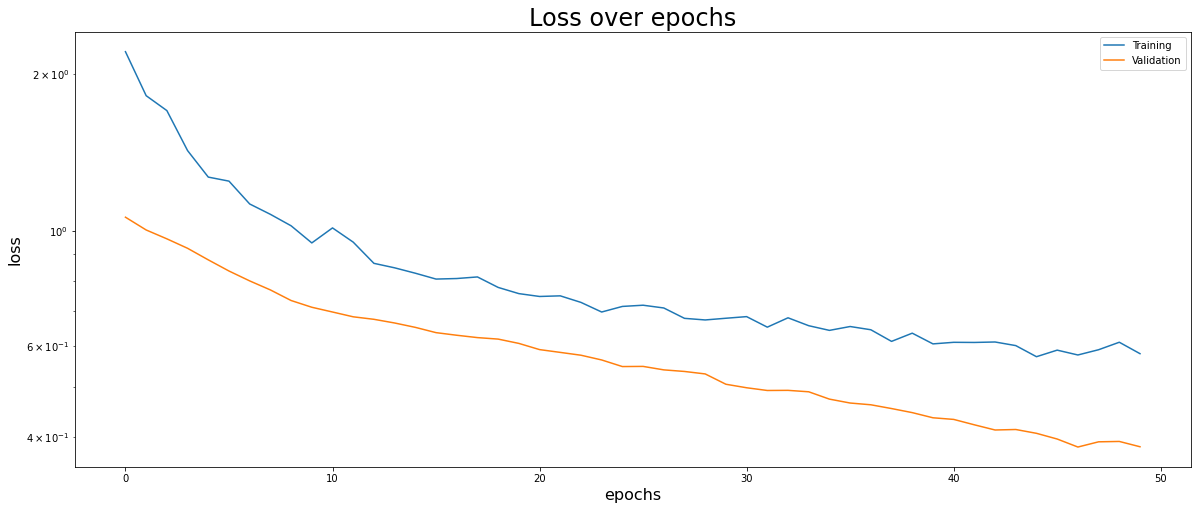

In [28]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over epochs')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

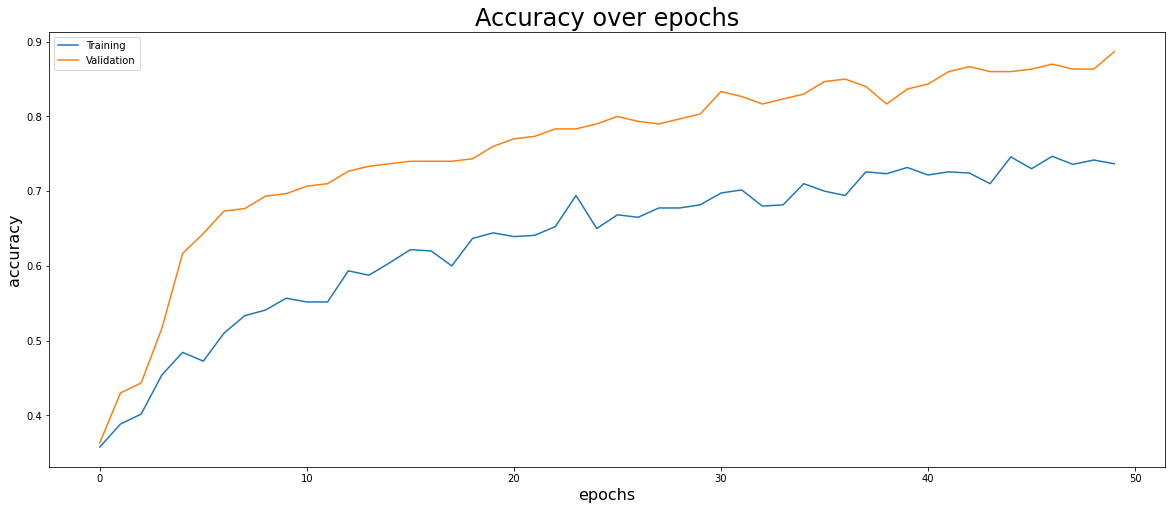

In [29]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation']);

# Invariant Properties of Model

## Accuracy range and lack of overfitting

In [30]:
assert train_metric > .85

In [31]:
assert test_metric > .85

In [32]:
assert train_metric - test_metric < .05

## Invariants of the model itself (without using data on it)
Could be
* effective depth of tree (if decision tree has been used as architecture instead of NN)
* distribution of weights
* actual normalization

**We do use these properties as we want to treat the model as a black box to make it interchangable**

# Invariants also useful for monitoring and analyzis - not using GT

In [33]:
y_pred = model.predict(X).argmax(axis=1)
y_pred.shape

(1500,)

In [34]:
# np.unique(y - y_pred, return_counts=True)

## Distribution of Output Class

In [35]:
values, counts = np.unique(y_pred, return_counts=True)
values, counts

(array([0, 1, 2]), array([566, 491, 443]))

In [36]:
# equal distribution around classes expected
tolerance = 0.15
expected_count = len(X) / 3
for count in counts:
    assert count in range(int(expected_count * (1 - tolerance)), int(expected_count * (1 + tolerance)))

In [37]:
range(int(expected_count * (1 - tolerance)), int(expected_count * (1 + tolerance)))

range(425, 575)

## Distribution of certainty

In [38]:
y_pred_probas = model.predict(X).max(axis=1)
y_pred_probas.shape

(1500,)

In [39]:
y_pred_probas.min(), y_pred_probas.mean(), y_pred_probas.max()

(0.47637764, 0.74088156, 0.99974126)

In [40]:
assert y_pred_probas.min() > .4

In [41]:
assert y_pred_probas.mean() > 0.7

In [42]:
assert y_pred_probas.max() > 0.99

## In Monitoring both could be treated as a distribution and compared to the training reference

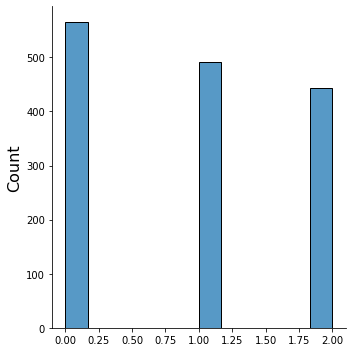

In [43]:
sns.displot(y_pred);

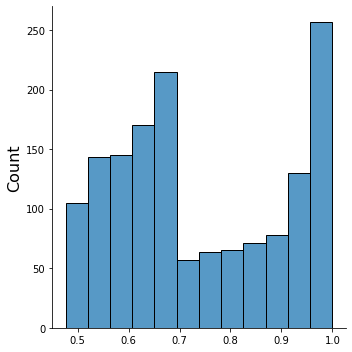

In [44]:
sns.displot(y_pred_probas);

## Since at this point we just have this one dataset, we can try with train vs test

In [45]:
y_train_pred_probas = model.predict(X_train).max(axis=1)
y_test_pred_probas = model.predict(X_val).max(axis=1)

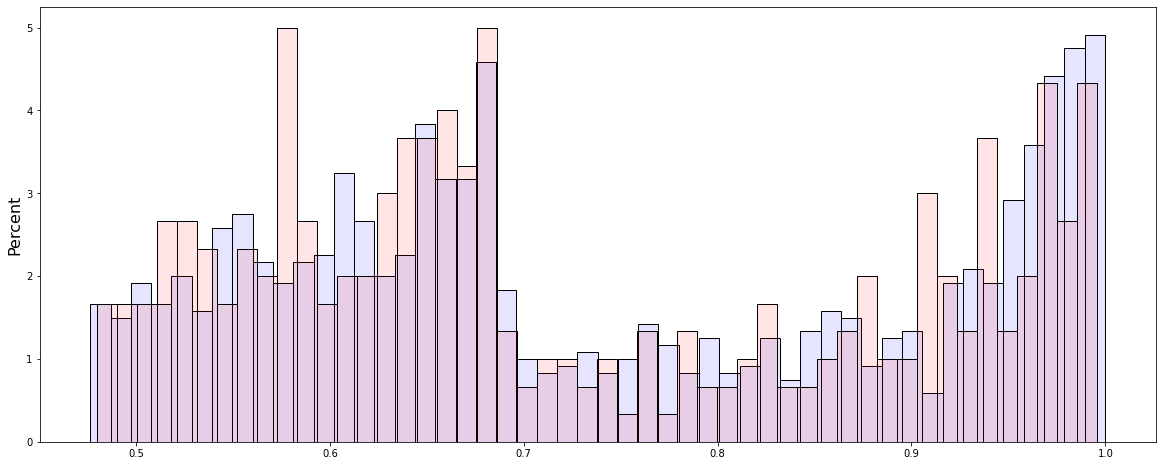

In [46]:
alpha=0.1
sns.histplot(y_train_pred_probas, color='blue', bins=50, stat='percent', alpha=alpha);
sns.histplot(y_test_pred_probas, color='red', bins=50, stat='percent', alpha=alpha);

In [47]:
y_train_pred = model.predict(X_train).argmax(axis=1)
y_test_pred = model.predict(X_val).argmax(axis=1)

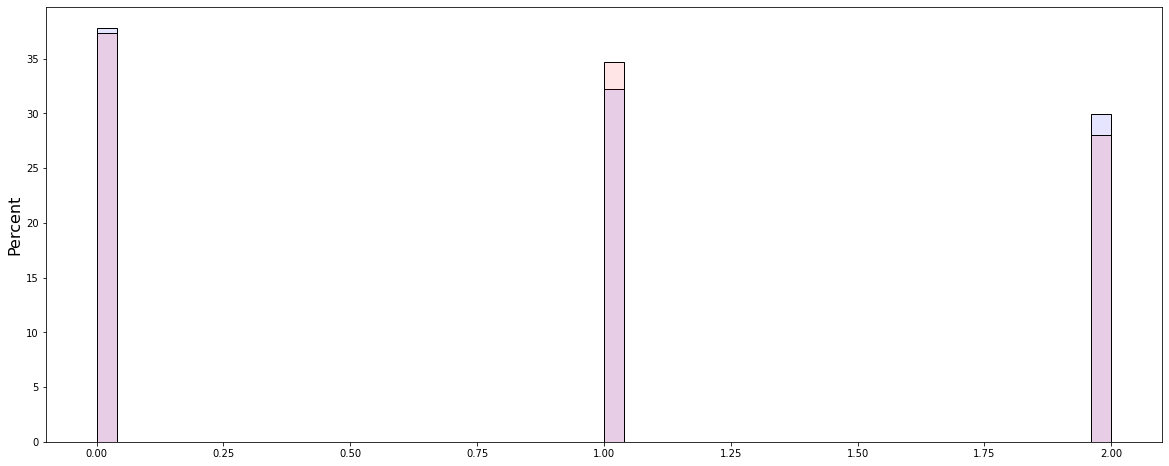

In [48]:
alpha=0.1
sns.histplot(y_train_pred, color='blue', bins=50, stat='percent', alpha=alpha);
sns.histplot(y_test_pred, color='red', bins=50, stat='percent', alpha=alpha);

## We can have a couple of statistical tests (more valuable in monitoring and real prod data)

In [50]:
# Colab
# !pip install -q evidently

     |████████████████████████████████| 11.9 MB 36.2 MB/s 
     |████████████████████████████████| 636 kB 78.1 MB/s 


In [51]:
from evidently.analyzers.stattests.jensenshannon import jensenshannon_stat_test
from evidently.analyzers.stattests.kl_div import kl_div_stat_test
from evidently.analyzers.stattests.ks_stattest import ks_stat_test
from evidently.analyzers.stattests.psi import psi_stat_test
from evidently.analyzers.stattests.wasserstein_distance_norm import wasserstein_stat_test

In [52]:
wasserstein_stat_test(y_train_pred_probas, y_test_pred_probas, 'num', threshold=None)

StatTestResult(drift_score=0.10123189750540715, drifted=True, actual_threshold=0.1)

In [53]:
ks_stat_test(y_train_pred_probas, y_test_pred_probas, 'num', threshold=None)

StatTestResult(drift_score=0.21831465443946152, drifted=False, actual_threshold=0.05)

In [54]:
psi_stat_test(pd.Series(y_train_pred_probas), pd.Series(y_test_pred_probas), 'num', threshold=None)

StatTestResult(drift_score=0.05021631741232406, drifted=False, actual_threshold=0.1)

In [55]:
jensenshannon_stat_test(pd.Series(y_train_pred), pd.Series(y_test_pred), 'cat', threshold=None)

StatTestResult(drift_score=0.019625408694546043, drifted=False, actual_threshold=0.1)

In [56]:
psi_stat_test(pd.Series(y_train_pred), pd.Series(y_test_pred), 'cat', threshold=None)

StatTestResult(drift_score=0.0030818654162898798, drifted=False, actual_threshold=0.1)

In [57]:
kl_div_stat_test(pd.Series(y_train_pred), pd.Series(y_test_pred), 'cat', threshold=None)

StatTestResult(drift_score=0.0015374932635726854, drifted=False, actual_threshold=0.1)

# Checking against "future" data

Since we are simulating production data we have access to data up 36 months from now

In [58]:
months_from_now = 36
df_prod = pd.read_csv(f'https://raw.githubusercontent.com/openknowledge/mlops-data2day/main/data/month-{months_from_now}.csv', delimiter=';')

In [59]:
X_prod = df_prod.drop(['risk', 'group', 'group_name'], axis='columns').values
X.shape

(1500, 6)

In [60]:
y_prod_pred = model.predict(X_prod).argmax(axis=1)
y_prod_pred_probas = model.predict(X_prod).max(axis=1)

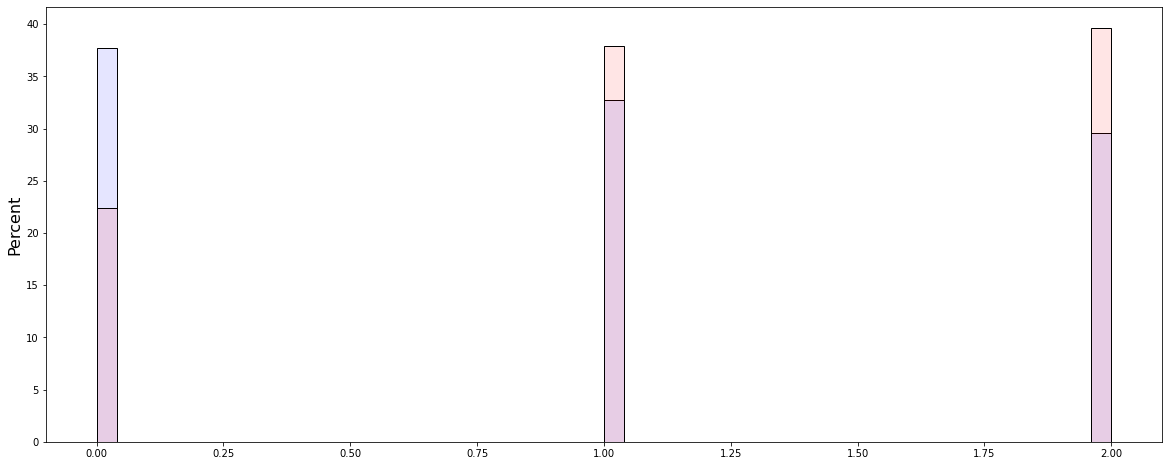

In [61]:
alpha=0.1
sns.histplot(y_pred, color='blue', bins=50, stat='percent', alpha=alpha);
sns.histplot(y_prod_pred, color='red', bins=50, stat='percent', alpha=alpha);

In [62]:
result = jensenshannon_stat_test(pd.Series(y_pred), pd.Series(y_prod_pred), 'cat', threshold=None)
result

StatTestResult(drift_score=0.12068095446082758, drifted=True, actual_threshold=0.1)

In [63]:
assert result.drifted

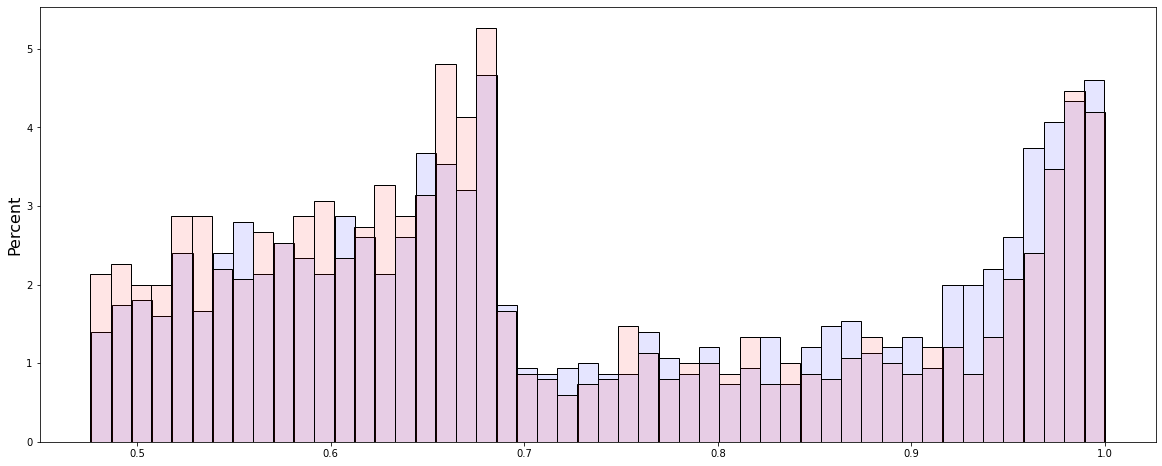

In [64]:
alpha=0.1
sns.histplot(y_pred_probas, color='blue', bins=50, stat='percent', alpha=alpha);
sns.histplot(y_prod_pred_probas, color='red', bins=50, stat='percent', alpha=alpha);

In [65]:
# result = ks_stat_test(pd.Series(y_pred_probas), pd.Series(y_prod_pred_probas), 'num', threshold=None)
# Wasserstein seems to better reflect our intuition here 
result = wasserstein_stat_test(pd.Series(y_pred_probas), pd.Series(y_prod_pred_probas), 'num', threshold=None)
result

StatTestResult(drift_score=0.15478346224121733, drifted=True, actual_threshold=0.1)

In [66]:
assert result.drifted

# Pre Processing - TODO - extend to all variables

Is the data feed into the model in the accepted range? Range is what has been covered by training data at all

In [67]:
age_range=range(10, 150)
power_range=range(50, 250)
def check_range(age, power):
    return age in age_range and power in power_range

In [68]:
assert check_range(age=30, power=150)

In [69]:
assert check_range(age=130, power=350) == False

# Post Processing

* are we certain enough, i.e. is the proba above a certain threshold? 
* if not fall back onto very simple rule system
* rule system should have high bias (underfit), but should be pretty robust to changes in input 

In [70]:
LOW_RISK = 2
MEDIUM_RISK = 1
HIGH_RISK = 0

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [72]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(3)
base_clf = RandomClassifier()    
base_clf.score(X, y)        

0.3253333333333333

In [73]:
# just return most frequent value might be a baseline
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([465, 390, 345]))

In [74]:
class NaiveClassifier(ClassifierBase):
    def predict_single(self, x):
        return HIGH_RISK
base_clf = NaiveClassifier()    
base_clf.score(X, y)    

0.3873333333333333

In [75]:
df.columns

Index(['training', 'age', 'emergency_breaking', 'braking_distance', 'power',
       'miles', 'risk', 'group_name', 'group'],
      dtype='object')

In [76]:
class BaseLineClassifier(ClassifierBase):
    def predict_single(self, x):
        training, age, emergency_breaking, braking_distance, power, miles = x
#         print(age, power, miles)
        if training: 
            return LOW_RISK
        if age < 30:
            if power > 130:
                return HIGH_RISK
            else:
                return MEDIUM_RISK
        if age > 50:
            return HIGH_RISK
        if emergency_breaking:
            return LOW_RISK
        if miles > 50:
            return HIGH_RISK
        if miles > 30:
            return MEDIUM_RISK
        # default
        return LOW_RISK
base_clf = BaseLineClassifier() 
base_clf.score(X, y)

0.586

# Saving Model

In [77]:
# model.save?

In [78]:
model.save('classifier.h5', save_format='h5')

In [79]:
model.save('classifier', save_format='tf')

In [80]:
!ls -l

total 340
drwxr-xr-x 4 root root   4096 Sep  4 16:54 classifier
-rw-r--r-- 1 root root 338288 Sep  4 16:54 classifier.h5
drwxr-xr-x 1 root root   4096 Aug 31 13:47 sample_data


In [81]:
!ls -l classifier/

total 336
drwxr-xr-x 2 root root   4096 Sep  4 16:54 assets
-rw-r--r-- 1 root root  22654 Sep  4 16:54 keras_metadata.pb
-rw-r--r-- 1 root root 310761 Sep  4 16:54 saved_model.pb
drwxr-xr-x 2 root root   4096 Sep  4 16:54 variables


In [ ]:
!tar czvf classifier.tgz ./classifier

./classifier/
./classifier/keras_metadata.pb
./classifier/saved_model.pb
./classifier/assets/
./classifier/variables/
./classifier/variables/variables.index
./classifier/variables/variables.data-00000-of-00001


In [ ]:
!ls -l

total 9328
-rw-r--r-- 1 olli olli 6752423 Aug 18 11:03 analysis.ipynb
drwxr-xr-x 4 olli olli    4096 Sep  4 17:20 classifier
-rw-r--r-- 1 olli olli  337864 Sep  4 17:20 classifier.h5
-rw-r--r-- 1 olli olli  284330 Sep  4 17:20 classifier.tgz
-rw-r--r-- 1 olli olli 1071957 Sep  4 17:20 exploration.ipynb
-rw-r--r-- 1 olli olli 1090452 Sep  4 17:02 sandbox.ipynb
